In [16]:
import argparse
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tlo import Date
from tlo.analysis.utils import (
    extract_results,
    get_color_cause_of_death_or_daly_label,
    summarize,
    parse_log_file
)
import geopandas as gpd

In [17]:
results_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs-2025-08-26T082255Z')

output_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs-2025-08-26T082255Z')

In [18]:

min_year = 2026
max_year = 2029
spacing_of_years = 1
PREFIX_ON_FILENAME = '1'

scenario_names = ["baseline", "ssp126_highest", "ssp126_lowest", "ssp126_mean", "ssp245_highest", "ssp245_lowest", "ssp245_mean",  "ssp585_highest", "ssp585_lowest", "ssp585_mean"]

scenario_colours = ['#0081a7', '#00afb9', '#FEB95F', '#fed9b7', '#f07167']*4


vmin = 0.5e+06
vmax = 2.4e+06


In [19]:

    TARGET_PERIOD = (Date(min_year, 1, 1), Date(max_year, 12, 31))

    def get_num_treatments_total_summary(_df):
        """Return the total number of treatments per month within TARGET_PERIOD"""
        _df['date'] = pd.to_datetime(_df['date'])
    
        # filter to target period
        df_period = _df.loc[_df['date'].between(*TARGET_PERIOD)].copy()
        df_period['month'] = df_period['date'].dt.to_period('M')
    
        monthly_totals = {}
    
        for month, group in df_period.groupby('month'):
            total = {}
            for d in group['hsi_event_key_to_counts']:
                for k, v in d.items():
                    total[k] = total.get(k, 0) + v
            monthly_totals[month] = sum(total.values())
    
        return pd.Series(monthly_totals, name="total_treatments")
    
    def get_num_treatments_total_delayed(_df):
        """Return the total number of delayed treatments per month within TARGET_PERIOD"""
        _df['date'] = pd.to_datetime(_df['date'])
    
        # filter to target period
        df_period = _df.loc[_df['date'].between(*TARGET_PERIOD)].copy()
        df_period['month'] = df_period['date'].dt.to_period('M')
    
        monthly_totals = {}
    
        for month, group in df_period.groupby('month'):
            total = {}
            for d in group['weather_delayed_hsi_event_key_to_counts']:
                for k, v in d.items():
                    total[k] = total.get(k, 0) + v
            monthly_totals[month] = sum(total.values())
    
        return pd.Series(monthly_totals, name="total_delayed_treatments")
    
    
    def get_num_treatments_total_cancelled(_df):
        """Return the total number of cancelled treatments per month within TARGET_PERIOD"""
        _df['date'] = pd.to_datetime(_df['date'])
    
        # filter to target period
        df_period = _df.loc[_df['date'].between(*TARGET_PERIOD)].copy()
        df_period['month'] = df_period['date'].dt.to_period('M')
    
        monthly_totals = {}
    
        for month, group in df_period.groupby('month'):
            total = {}
            for d in group['weather_cancelled_hsi_event_key_to_counts']:
                for k, v in d.items():
                    total[k] = total.get(k, 0) + v
            monthly_totals[month] = sum(total.values())
    
        return pd.Series(monthly_totals, name="total_cancelled_treatments")

    def get_population_for_year(_df):
        """Returns the population in the year of interest"""
        _df['date'] = pd.to_datetime(_df['date'])
        filtered_df = _df.loc[_df['date'].between(*TARGET_PERIOD)]
        numeric_df = filtered_df.drop(columns=['female', 'male'], errors='ignore')
        population_sum = numeric_df.sum(numeric_only=True)
        return population_sum

    target_year_sequence = range(min_year, max_year, spacing_of_years)
    
    all_scenarios_appointment_difference_mean = {}
    all_scenarios_appointment_difference_lower = {}
    all_scenarios_appointment_difference_upper = {}

    for draw in range(len(scenario_names)):
        make_graph_file_name = lambda stub: output_folder / f"{PREFIX_ON_FILENAME}_{stub}_{draw}.png"  # noqa: E731

        all_years_data_treatments_mean = {}
        all_years_data_treatments_upper = {}
        all_years_data_treatments_lower = {}

        all_years_data_never_ran_mean = {}
        all_years_data_never_ran_upper = {}
        all_years_data_never_ran_lower = {}

        all_years_data_difference_mean = {}
        all_years_data_difference_lower = {}
        all_years_data_difference_upper = {}

        for target_year in target_year_sequence:
            TARGET_PERIOD = (
                Date(target_year, 1, 1), Date(target_year, 12, 31))

            if draw == 0:
                all_years_data_treatments_mean[target_year] = pd.Series([0], name='mean')
                all_years_data_treatments_lower[target_year] = pd.Series([0], name='lower')
                all_years_data_treatments_upper[target_year] = pd.Series([0], name='upper')
                
                all_years_data_difference_mean[target_year] = pd.Series([0], name='mean')
                all_years_data_difference_lower[target_year] = pd.Series([0], name='mean')
                all_years_data_difference_upper[target_year] = pd.Series([0], name='mean')



            else:
                # Total treatments

                num_treatments_total = summarize(extract_results(
                    results_folder,
                    module='tlo.methods.healthsystem.summary',
                    key='hsi_event_counts',
                    custom_generate_series=get_num_treatments_total_summary,
                    do_scaling=True
                ),
                    only_mean=False,
                    collapse_columns=True,
                )[draw]
                all_years_data_treatments_mean[target_year] = num_treatments_total['mean']
                all_years_data_treatments_lower[target_year] = num_treatments_total['lower']
                all_years_data_treatments_upper[target_year] = num_treatments_total['upper']

                # Weather delayed appointments

                num_weather_delayed_appointments = summarize(
                    extract_results(
                        results_folder,
                        module='tlo.methods.healthsystem.summary',
                        key='weather_delayed_hsi_event_counts',
                        custom_generate_series=get_num_treatments_total_delayed,
                        do_scaling=True
                    ),
                    only_mean=False,
                    collapse_columns=True,
                )[draw]

                # Weather cancelled appointments
                num_weather_cancelled_appointments = summarize(
                    extract_results(
                        results_folder,
                        module='tlo.methods.healthsystem.summary',
                        key='weather_cancelled_hsi_event_counts',
                        custom_generate_series=get_num_treatments_total_cancelled,
                        do_scaling=True
                    ),
                    only_mean=False,
                    collapse_columns=True,
                )[draw]
                
                all_years_data_difference_mean[target_year] = (num_weather_delayed_appointments['mean'] + num_weather_cancelled_appointments['mean'])/num_treatments_total['mean']
                all_years_data_difference_lower[target_year] = ( num_weather_delayed_appointments['lower'] + num_weather_cancelled_appointments['lower'])/num_treatments_total['lower']
                all_years_data_difference_upper[target_year] = (num_weather_delayed_appointments['upper'] + num_weather_cancelled_appointments['upper'])/num_treatments_total['upper']
        
        all_scenarios_appointment_difference_mean[scenario_names[draw]] = all_years_data_difference_mean
        all_scenarios_appointment_difference_lower[scenario_names[draw]] = all_years_data_difference_lower
        all_scenarios_appointment_difference_upper[scenario_names[draw]] = all_years_data_difference_upper






/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:459: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:459: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:459: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:459: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

In [20]:

climate_ssps = ["ssp126", "ssp245", "ssp585"]
climate_model_ensemble_models = ["lowest", "mean", "highest"]

climate_all_scenarios = {}

for ssp in climate_ssps:
    for model in climate_model_ensemble_models:
        scenario_key = f"{ssp}_{model}"
        
        df = pd.read_csv(
            f'/Users/rem76/PycharmProjects/TLOmodel/resources/climate_change_impacts/'
            f'ResourceFile_Precipitation_Disruptions_{ssp}_{model}.csv'
        )
        df = df[df["year"] > 2025]
        df = df[df["year"] <=2028]
        # Compute average mean_all_service per year-month
        avg_df = df.groupby(["year", "month"], as_index=False)["mean_all_service"].mean()
        
        # Store values as a list (like appointment_all_scenarios)
        climate_all_scenarios[scenario_key] = avg_df["mean_all_service"].values.tolist()


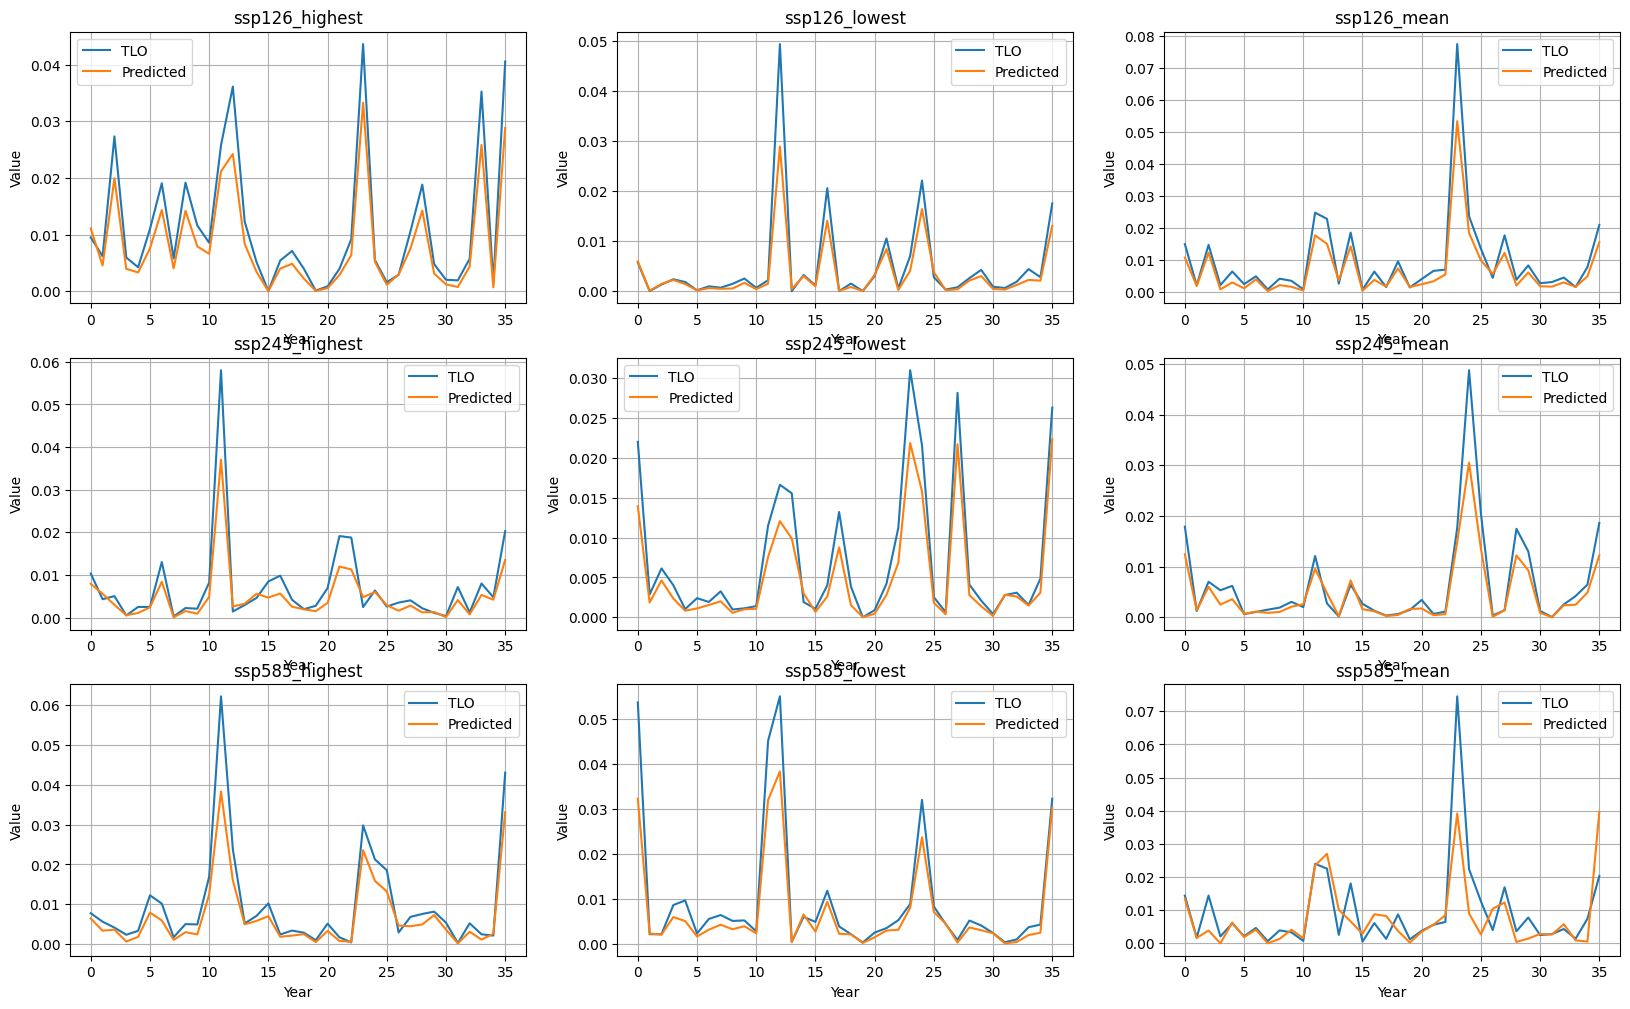

In [25]:
appointment_all_scenarios = {}
for scenario_name in scenario_names:
    if scenario_name == "Baseline":
        continue
    appointment_by_scenario = all_scenarios_appointment_difference_mean[scenario_name]
    for year in appointment_by_scenario.keys():
            appointment_all_years = [
        value
        for year in appointment_by_scenario.keys()
        for value in appointment_by_scenario[year].values.tolist()
    ]
        
    appointment_all_scenarios[scenario_name] = appointment_all_years


scenario_names = [name for name in appointment_all_scenarios.keys() if name != "baseline"]

fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = axes.flatten()  # Flatten to easily index

for i, scenario_name in enumerate(scenario_names):
    ax = axes[i]
    ax.plot(np.array(appointment_all_scenarios[scenario_name], dtype=float) * 0.6, label="TLO")
    ax.plot(climate_all_scenarios[scenario_name], label="Predicted")
    
    ax.set_xlabel("Year")
    ax.set_ylabel("Value")
    ax.set_title(f"{scenario_name}")
    ax.grid(True)
    ax.legend()

In [36]:
weather_data_prediction_monthly_original

,Unnamed: 0,Akasale Pvt Clinic,Area 30 Police Clinic,Balaka District Hospital,Bangwe Health Centre,Benga Health Centre,Bilira Health Centre,Bolero Rural Hospital,Bondo Health Centre,Bula Health Centre,...,Thumbwe Health Centre,Thunduwike Health Centre,Thyolo District Hospital,Usisya Health Centre,Utale 1 Health Centre,Utale 2 Health Centre,Wiliro Health Centre,Wimbe Health Centre,Zomba Central Prison Clinic,Zomba Mental Hospital
0,2024-1,335.133787,254.011145,284.815637,269.175342,419.119297,349.992354,366.150233,322.756259,229.278968,...,335.133787,211.993076,264.756581,427.126106,265.543232,265.543232,349.992354,196.439948,283.646976,283.646976
1,2024-2,308.709419,206.915435,230.754780,273.778540,280.380417,294.096214,320.355552,385.083936,188.868713,...,308.709419,159.794806,308.342145,274.829166,316.086019,316.086019,294.096214,157.893871,309.880797,309.880797
2,2024-3,78.624252,63.549527,63.197634,57.921506,296.770580,315.818936,328.047773,108.979091,49.798687,...,78.624252,132.119286,97.113763,344.029752,54.197226,54.197226,315.818936,79.115827,53.638405,53.638405
3,2024-4,35.199533,3.023152,14.129093,30.054194,106.173303,148.021602,164.394634,67.246953,9.287518,...,35.199533,34.009058,44.813565,131.124017,26.827235,26.827235,148.021602,6.786979,32.595995,32.595995
4,2024-5,17.362986,0.000000,2.272944,7.488124,16.632777,23.071730,12.615090,25.318814,0.000000,...,17.362986,1.172067,18.331773,19.813006,6.717125,6.717125,23.071730,0.000000,5.456333,5.456333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2070-8,9.005116,0.000000,1.461337,1.201473,9.477852,7.253222,0.000000,27.024625,0.000000,...,9.005116,0.000000,17.932312,11.992594,1.418211,1.418211,7.253222,0.000000,2.834265,2.834265
560,2070-9,7.425438,2.243761,0.000000,1.167826,4.848541,8.072002,0.000000,1.999829,0.000000,...,7.425438,0.000000,1.092275,7.426709,0.000000,0.000000,8.072002,0.000000,0.000000,0.000000
561,2070-10,3.963467,2.501991,4.243432,3.078727,26.898598,12.690413,2.585748,3.441474,3.262938,...,3.963467,2.258187,6.654248,25.000826,1.229522,1.229522,12.690413,1.007023,2.436065,2.436065
562,2070-11,42.600796,7.429447,15.984151,28.122744,19.711709,10.452729,3.661188,66.562414,5.180262,...,42.600796,0.000000,58.184997,15.224262,23.659305,23.659305,10.452729,1.353024,30.928490,30.928490


85.64134843286443
106.82201703137791
121.47385476971755


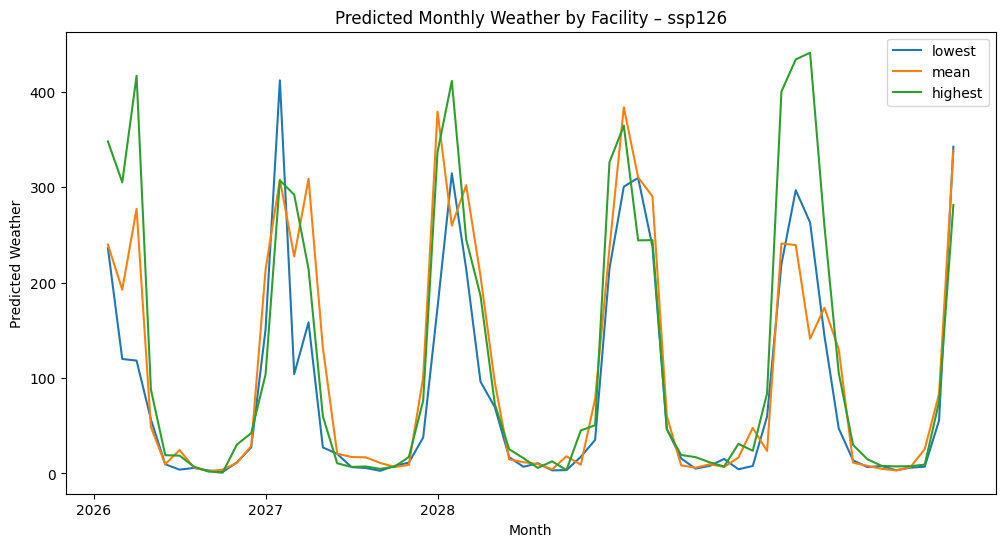

90.56277386962047
90.04866293241733
106.16890982048184


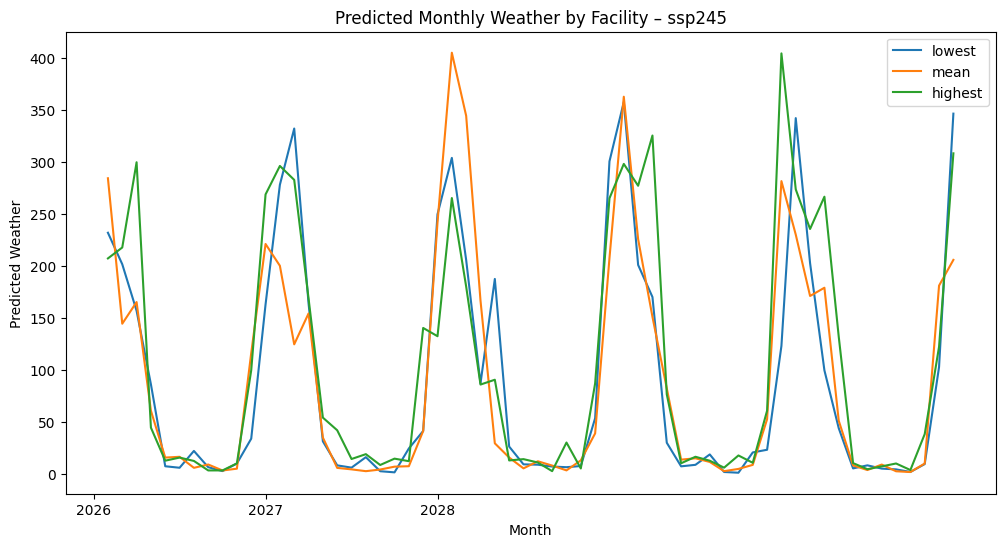

96.15598377884822
103.41848692453088
104.2308091471211


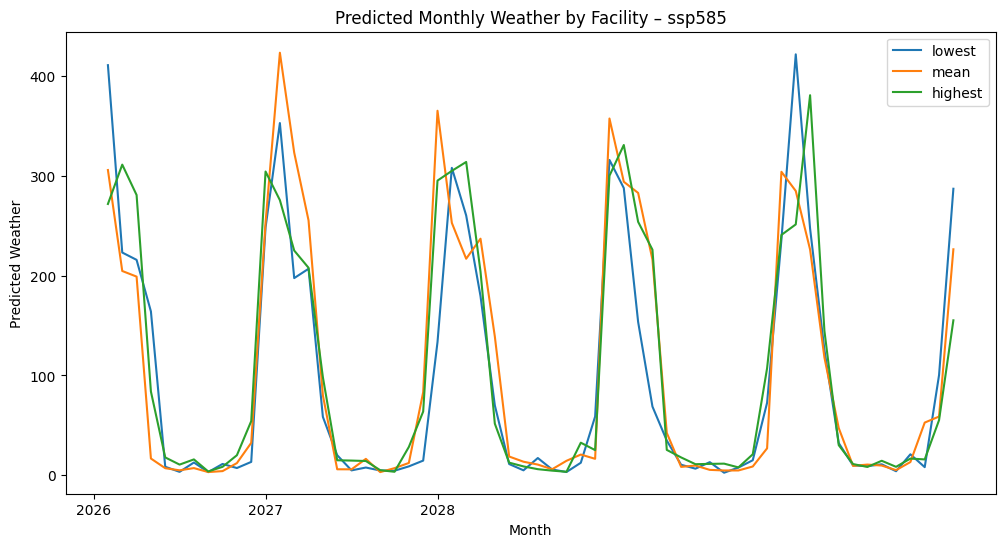

In [65]:
ssps = ["ssp126", "ssp245", "ssp585"]
models = ["lowest", "mean", "highest"]
service = "ANC"

for ssp_scenario in ssps:
    plt.figure(figsize=(12, 6))
    
    for model_type in models:
        weather_data_prediction_monthly_original = pd.read_csv(
            f"/Users/rem76/Desktop/Climate_change_health/Data/Precipitation_data/Downscaled_CMIP6_data_CIL/{ssp_scenario}/{model_type}_monthly_prediction_weather_by_facility_{service}.csv",
            dtype={'column_name': 'float64'}
        )
        
        mask = (weather_data_prediction_monthly_original.index > 23) & \
               (weather_data_prediction_monthly_original.index < ((2045 - 2024)*4))
        weather_data_prediction_monthly_original = weather_data_prediction_monthly_original.loc[mask]

        weather_data_prediction_monthly_average_facilities = weather_data_prediction_monthly_original.iloc[:, 1:].mean(axis=1)
        print(weather_data_prediction_monthly_average_facilities.mean(axis = 0))
        
        plt.plot(weather_data_prediction_monthly_average_facilities, label=model_type)
    
    plt.xticks(ticks=[23, 35, 47], labels=["2026", "2027", "2028"])
    plt.title(f"Predicted Monthly Weather by Facility – {ssp_scenario}")
    plt.xlabel("Month")
    plt.ylabel("Predicted Weather")
    plt.legend()
    plt.show()